
<center><h1>Analysis of Trending Youtube Videos</h1></center>
<hr>


### Author(s)

- Nur Syafiqah Binte Mohamed Raihan (@syaf99)

- Tan Zi Rong (@Zirong27)

from class Sat 7.00pm

### Executive Summary

This report aims to determine the relative importance of different factors on the popularity of a video. This will be done through data visualisation and descriptive analytics.



### Problem Statement 

<hr>

One third of all people on the internet watch billions of hours of video on YouTube. Both of us are also avid audience of the myriad of youtube videos out there but why are some videos more popular than others? 

As such, we have come up with some hypotheses of factors that make a Youtube video popular: 
1. Publish Time: The best time to publish a youtube video is 5pm. (according to https://www.swishvideoapp.com/when-is-the-best-time-to-post-videos-on-youtube/)
2. Tags: The higher the occurence of a tag (amongst the trending videos), the more views videos of similar content is able to get. (according to https://backlinko.com/hub/youtube/tags). 
3. Ratio of likes and dislikes: Videos with a higher proportion of likes over dislikes will be more popular. 
4. Entropy of thumbnail: The higher the entropy of the thumbnail, the higher the views a Youtube video will garner. 
5. Contrast of thumbnail images: The higher the contrast of the thumbnail, the higher the views a Youtube video will garner.

'Popular' here will refer to the weekly trending videos. Some factors we will look at are published time, tags, ratio of likes and dislikes, description and comments settings. Our sample demographic will be the United States. At the end of this study, youtubers will be able to improve the popularity of their content towards their english-speaking audience.

**Dataset:**
- https://www.kaggle.com/datasnaek/youtube-new/downloads/youtube-new.zip/114


**Literature / Articles referred to (where necessary):**
- 37 Staggering Video Marketing Statistics for 2018 ([https://www.wordstream.com/blog/ws/2017/03/08/video-marketing-statistics) retrieved on 29 May 2019
- WHEN IS THE BEST TIME TO POST VIDEOS ON YOUTUBE? (https://www.swishvideoapp.com/when-is-the-best-time-to-post-videos-on-youtube/) retrieved on 30 May 2019
- Tags (https://backlinko.com/hub/youtube/tags) retrieved on 30 May 2019
- What does entropy mean in this context? (https://stackoverflow.com/questions/40596026/what-does-entropy-mean-in-this-context) retrieved on 30 May 2019



### Dataset 

The dataset is in CSV format, taken from kaggle.com website. 

**Dataset used:**
- Source 1 (https://www.kaggle.com/datasnaek/youtube-new#CAvideos.csv) retrieved on 29 May 2019



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import requests

### Overview

Getting an overview of the dataset

In [2]:
# saving the csv file into a dataframe
US_videos = pd.read_csv('USvideos.csv')

# dropping columns that will not be analysed
US_videos = US_videos.drop(columns=["comments_disabled","ratings_disabled", "video_error_or_removed", "comment_count"])

#replacing values that have 'NaN' to an empty string'
US_videos["description"] = US_videos["description"].fillna(value='') 

US_videos.head(1)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,thumbnail_link,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,SHANTELL'S CHANNEL - https://www.youtube.com/s...


In [3]:
# Understanding the dataset
US_videos.info()
US_videos['views'].describe()
pd.DataFrame(US_videos.groupby(['title', 'video_id']).size()).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40949 entries, 0 to 40948
Data columns (total 12 columns):
video_id          40949 non-null object
trending_date     40949 non-null object
title             40949 non-null object
channel_title     40949 non-null object
category_id       40949 non-null int64
publish_time      40949 non-null object
tags              40949 non-null object
views             40949 non-null int64
likes             40949 non-null int64
dislikes          40949 non-null int64
thumbnail_link    40949 non-null object
description       40949 non-null object
dtypes: int64(4), object(8)
memory usage: 3.7+ MB
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 6463 entries, (#184 Making a PCB using EasyEDA. // Review, BPmgDhwbd1w) to (😱 $1,145 iPhone Case!!, r3J784MSRyQ)
Data columns (total 1 columns):
0    6463 non-null int64
dtypes: int64(1)
memory usage: 175.9+ KB


The dataset consists of 40949 rows.

**General information:**
    <br>● The average number of views is 2360000
    <br>● There are 6463 unique videos

**1. Published Time**

Hypothesis: The best time to publish a youtube video is 5pm.

In [4]:
# Creating a new dataframe with columns views and publish_time.
US_videos_publish_time = US_videos[['views','publish_time','channel_title']].copy()

# publish_time only keeps the hour in which the video was published
US_videos_publish_time['publish_time'] = US_videos_publish_time['publish_time'].str.slice(11,13).astype(int)

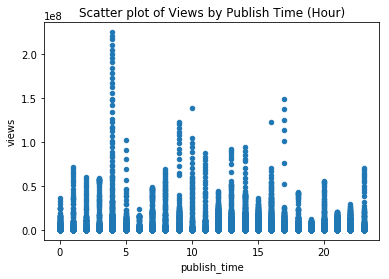

In [5]:
# Scatter plot to visualise correlation between likes and views
fig = plt.figure()
ax = fig.add_subplot(111)
US_videos_publish_time.plot(kind='scatter', x = 'publish_time', y = 'views',
                            title="Scatter plot of Views by Publish Time (Hour)", ax=ax, style=".")

The scatter plot above showed us that there was no clear correlation between publish time and number of views.

**2. Tags**

We wanted to find what kind of video content will attract the most views. 

Assumption: Tags are relevant to the context of the video.

Hypothesis: The higher the occurence of a tag (amongst the trending videos), the more views videos of similar content is able to get. 

To generate a word cloud, we cleaned the data by removing tags with '[none]' and unnecessary punctuation. 

In [6]:
US_videos_tags = US_videos['tags']
#US_videos_tags.sample(1).iloc[0]

In [7]:
US_videos_tags_list = list(US_videos_tags)
#US_videos_tags_list

In [8]:
# Cleaning of data
tags_step1 = []
for d in US_videos_tags_list :
    #remove 'none' (no tags)
    d2 = re.sub('none', '', d)
    d2 = re.sub('<[a-z]+/?>', '', d2)
    d2 = d2.strip().lower()   
    d2 = re.sub('[/(/)!-.+/:%;|/"_]',' ', d2)  #d2 = re.sub('[(-_,$\&""!|.;%)]', ' ', d2)
    d2 = d2.strip()
    tags_step1.append(d2)
tags_step1[0:2]

['shantell martin',
 'last week tonight trump presidency  last week tonight donald trump   john oliver trump   donald trump']

In [9]:
long_str_tags = ''
for d in tags_step1:
    long_str_tags += ' ' + d
long_str_tags[0:30]

' shantell martin last week ton'

To visualise the importance of certain tag phrases, we created a wordcloud of the tags from the cleaned dataset. The bigger the size of the word or phrase in the wordcloud, the more important or frequent it appears in the dataset. The most common words in the tags are music video, star wars, makeup tutorial and funny video.

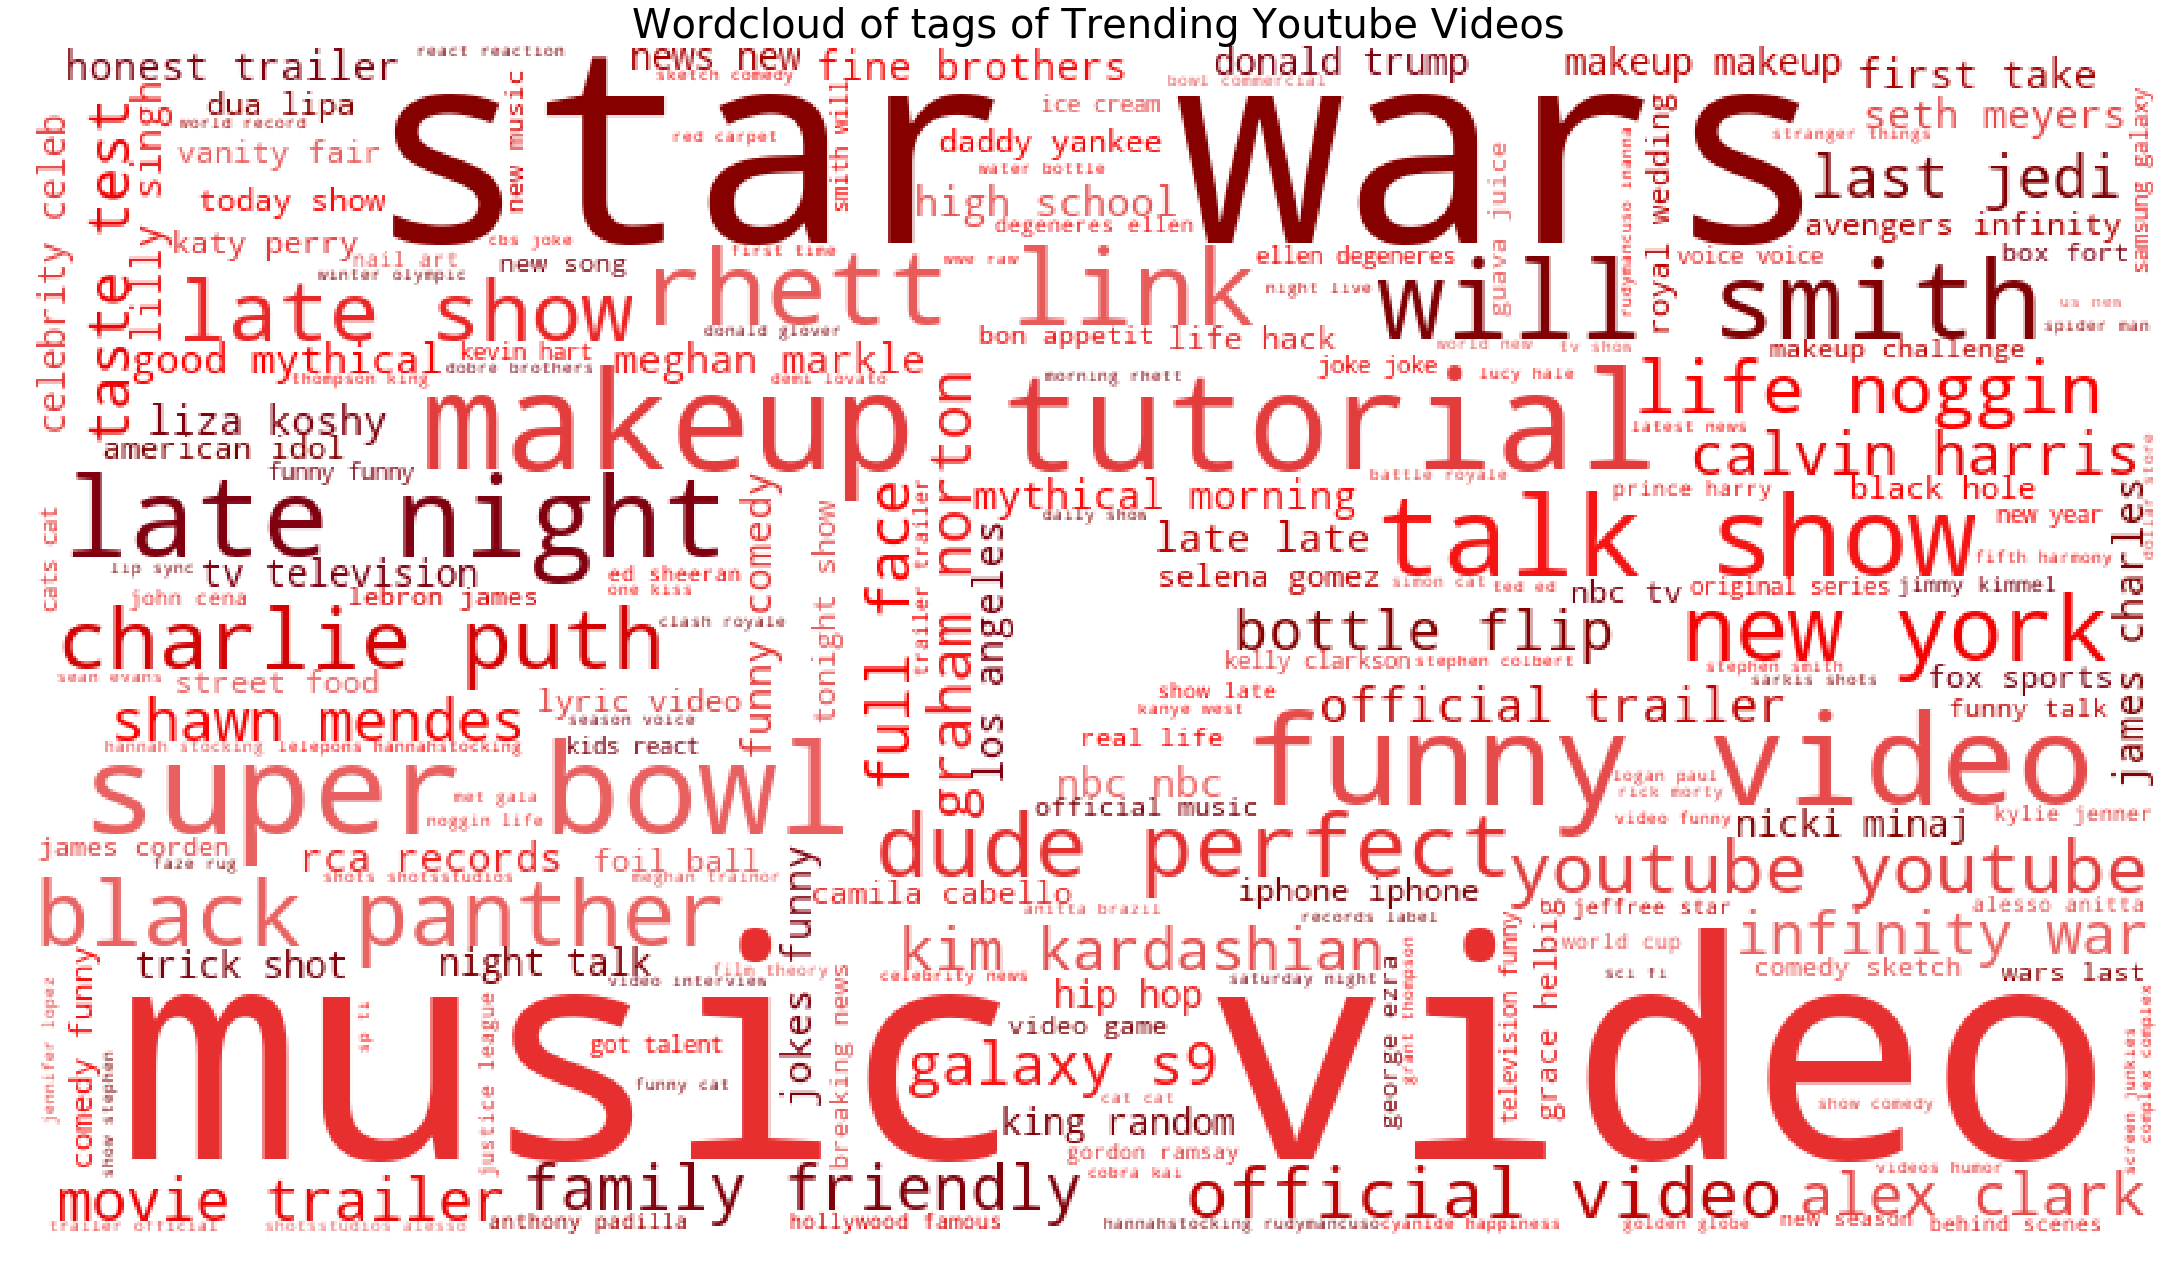

In [10]:
#youtube logo mask
youtube_mask = np.array(Image.open(requests.get('https://cdn1.techadvisor.co.uk/cmsdata/features/3681165/youtube-logo-png-2069_thumb800.png', stream=True).raw))

from matplotlib.colors import LinearSegmentedColormap
colors = ["#800013", "#800000", "#ef0404", "#ff0000", "#e23838", "#ea6b6b"]
cmap = LinearSegmentedColormap.from_list("mycmap", colors)


desc_wordcloud = WordCloud(background_color='white', stopwords=STOPWORDS, mask=youtube_mask, colormap=cmap).generate(long_str_tags)
plt.figure(figsize=(30,20),facecolor = 'white')
plt.imshow(desc_wordcloud)
plt.axis('off')
plt.title("Wordcloud of tags of Trending Youtube Videos", fontsize=40)
plt.tight_layout(pad=0)
plt.show()


# change font to Roboto-Regular:
# desc_wordcloud = WordCloud(background_color='white', stopwords=STOPWORDS, mask=youtube_mask, colormap=cmap, font_path=R"C:\\Users\User\Anaconda3\Lib\site-packages\matplotlib\mpl-data\fonts\ttf\Roboto-Regular.ttf").generate(words)


**Correlation between tags and popularity (number of views)**

In [11]:
US_tags_pop = {}
tags_dict = {"Tags (filtered by wordcloud)":[], "Average number of views according to specific tag":[]}

for tag in desc_wordcloud.words_:
    count=0
    for video in US_videos['tags']:
        if tag in video:
            if tag not in US_tags_pop:
                US_tags_pop[tag] = US_videos['views'][count]
            else:
                US_tags_pop[tag] += US_videos['views'][count]
        count+=1
        
no_of_vids_that_tag_appeared = {}
for tag in desc_wordcloud.words_:
    for video in US_videos['tags']:
        if tag in video:
            if tag not in no_of_vids_that_tag_appeared:
                no_of_vids_that_tag_appeared[tag] = 1
            else:
                no_of_vids_that_tag_appeared[tag] += 1
                
#no_of_vids_that_tag_appeared

for key,value in US_tags_pop.items():
    value = round(value / no_of_vids_that_tag_appeared[key],2)
    US_tags_pop[key] = value
    
for key,value in US_tags_pop.items():
    tags_dict["Tags (filtered by wordcloud)"].append(key)
    tags_dict["Average number of views according to specific tag"].append(value)
    

#tags_dict
#US_tags_pop
tags_pop_df = pd.DataFrame.from_dict(tags_dict)
#tags_pop_df.rename_axis("Tags (filtered by wordcloud)", axis='index', inplace=True)
#tags_pop_df.sort_values('Average number of views according to specific tag', inplace=True)
tags_pop_df.head()

,Tags (filtered by wordcloud),Average number of views according to specific tag
0,music video,5595665.62
1,star wars,1514896.51
2,makeup tutorial,1133645.13
3,funny video,1366606.50
4,super bowl,2393919.90


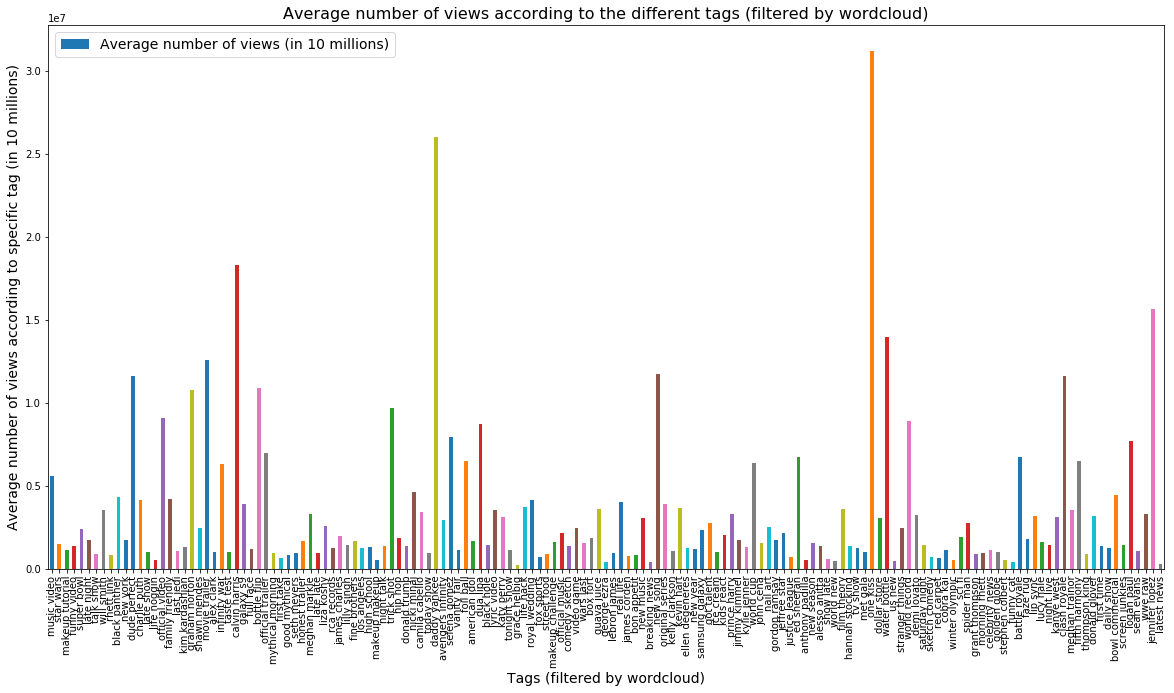

In [12]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

ax.set_title("Average number of views according to the different tags (filtered by wordcloud)", fontsize=16)

tags_pop_df.plot(kind='bar', x='Tags (filtered by wordcloud)', y='Average number of views according to specific tag', ax=ax)

ax.set_xlabel("Tags (filtered by wordcloud)", fontsize=14)

ax.set_ylabel('Average number of views according to specific tag (in 10 millions)', fontsize=14)

ax.legend(["Average number of views (in 10 millions)"], fontsize=14)

plt.show()

According to the wordcloud generated, it appears that the most common tag 'music video' did not garner the highest average number of views. Instead,
the 'one kiss' tag had the highest average number of views. Hence, it is proven that the hypothesis that the higher the occurence of a tag, the higher the video is ranked on Youtube in terms of viewership
is flawed, as there may other factors that can affect the popularity of a video more than the frequency of tags.

**3. Ratio of likes and dislikes**

Hypothesis: Videos with a higher proportion of likes over dislikes will be more popular. 

In [13]:
# Creating a new column to calculate proportion of likes over dislikes, rounded to 2 d.p.
US_videos_likes_proportion = US_videos.copy()
US_videos_likes_proportion = US_videos_likes_proportion[['views', 'likes', 'dislikes', 'title']]
US_videos_likes_proportion['Proportion of likes (%)'] = round(US_videos['likes']/(US_videos['likes']+US_videos['dislikes'])*100, 2)

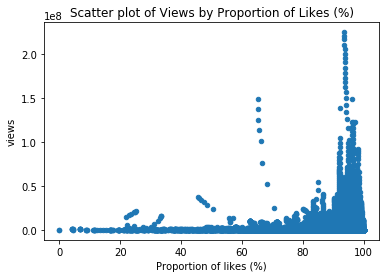

In [14]:
# Scatter plot to visualise correlation between likes and views
fig = plt.figure()
ax = fig.add_subplot(111)
US_videos_likes_proportion.plot(kind='scatter', x = 'Proportion of likes (%)', y = 'views',
                            title="Scatter plot of Views by Proportion of Likes (%)", ax=ax)

In [15]:
# Calculating correlation value between likes and views
US_videos_likes_proportion['Proportion of likes (%)'].corr(US_videos['views'])

0.026429898085062534

The scatter plot above indicates that there was no clear postive correlation between proportion of likes and views. The very low correlation value also suggests similar findings. However, we were surprised that videos with very low proportion of likes are also able to make it into the trending list. Hence, we explored certain examples below.

In [16]:
#Investigate outliers
title_df = US_videos_likes_proportion.sort_values('Proportion of likes (%)')[0:10]
title_df['title'].unique()

array(['Kelly Oubre Punches John Wall in the Lead during warriors wizards scuffle',
       'PSA from Chairman of the FCC Ajit Pai',
       'The FCC repeals its net neutrality rules',
       'LuLaRoe Consultant Mocks Those With Special Needs'], dtype=object)

The above are the title of videos with the lowest proportion of likes. We realised unlikable videos can garner traction and views too. This includes infamous actions such as mocking people with special needs. 

**4. Entropy of Thumbnail Images**

As thumbnails give the first impression that a person has of a video, it plays a critical part in garnering views. We used the skimage library to extract attributes like entropy and contrast from the thumbnail images used in trending videos and visualised these attributes against video popularity using a scatterplot to find out how does each of these attributes of a thumbnail affect the video's popularity.

Hypothesis: The higher the entropy of the thumbnail, the higher the views a Youtube video will garner. 

In [17]:
import skimage
from skimage import io, color, feature

In [18]:
entropy_col = {"Views":[], "Entropy":[]}
count = 0
img_missing_list = []
for i in US_videos['thumbnail_link'][0:100]:
    try:
        image = io.imread(i)  #io.imread converts image url to an array
        entropy_col["Views"].append(US_videos['views'][count]) 
        entropy_col["Entropy"].append(skimage.measure.shannon_entropy(image))
        count+=1
    except:
        img_missing_list.append(i)

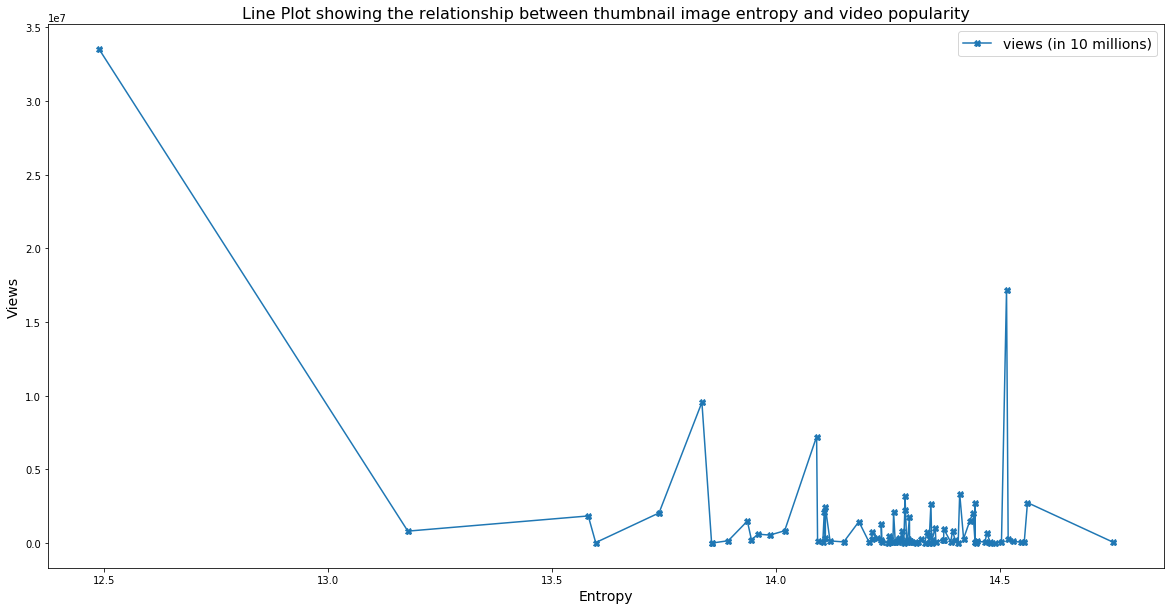

In [19]:
entropy_df = pd.DataFrame.from_dict(entropy_col)
entropy_df.sort_values('Entropy', inplace=True)
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

ax.set_title("Line Plot showing the relationship between thumbnail image entropy and video popularity", fontsize=16)

entropy_df.plot(kind='line', x='Entropy', y='Views', ax=ax, marker='X')

ax.set_xlabel("Entropy", fontsize=14)

ax.set_ylabel('Views', fontsize=14)

ax.legend(["views (in 10 millions)"], fontsize=14)

plt.show()

Entropy is a measure of image information content, which is interpreted as the average uncertainty of information source.  The chart above consists of 100 thumbnail images. 

From the line plot, we can observe a fluctuating trend, which suggests that entropy does not really affect the popularity of a video in terms of viewership.

**5. Contrast of thumbnail images**

Hypothesis: The higher the contrast of the thumbnail, the higher the views a Youtube video will garner.

In [20]:
contrast_col = {"Views":[], "Contrast":[]}
#compare_contrast = {''}
count = 0
for i in US_videos['thumbnail_link'][:100]:
    if i not in img_missing_list:
        image = io.imread(i)
        contrast_col["Views"].append(US_videos['views'][count]) 
        contrast = skimage.exposure.is_low_contrast(image)
        if contrast==False:
            contrast_col["Contrast"].append(1)
        else:
            contrast_col["Contrast"].append(2)
        count+=1
    
        
#contrast_col

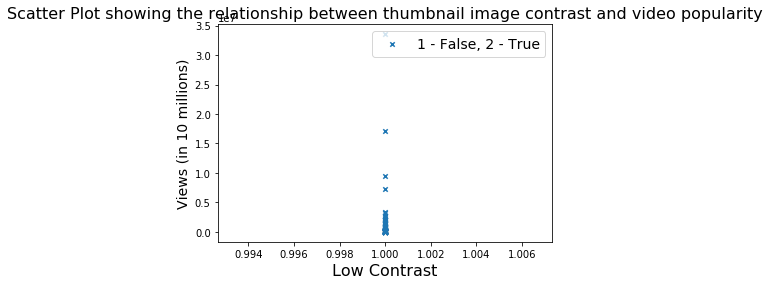

In [21]:
contrast_df = pd.DataFrame.from_dict(contrast_col)
#contrast_df.sort_values('Contrast', inplace=True)

fig = plt.figure()
ax = fig.add_subplot(111) 
contrast_df.plot(x='Contrast', y='Views', kind='scatter', ax=ax, marker='x')
ax.set_ylabel('Views (in 10 millions)', fontsize=14)
ax.set_xlabel('Low Contrast', fontsize=16)
ax.set_title("Scatter Plot showing the relationship between thumbnail image contrast and video popularity", fontsize=16)
ax.legend(["1 - False, 2 - True"], fontsize=14)

plt.show()

From the scatter plot, it can be inferred that in the sample dataset of thumbnail links from 100 trending videos, all the thumbnails have high contrast.

### Evalution

After analysing 4 different characteristics that make up a youtube video, we concluded that there is no one clear formula in producing a popular youtube video. From the above, we were surpised that publish time of the video does not have a correlation with popularity despite similar claims in many articles. Other characteristics such as entropy of the thumbnail also have very little correlation with popularity. 
<br>
<br>
Content wise, while there are certain content (eg. music videos, late night talk show) which comprise a higher proportion of videos amongst all the trending videos, we realised that it does not guarantee a video getting high views. The likeability of a video also have little correlation with number of views.
<br>
<br>
Our analysis are also limited to the dataset which only consists of trending videos.
<br>
<br>
Ultimately, we realise that similar to external trends, trends can change rapidly and having guidelines for the type of content does not guarantee views. Beyond the content of the video, we also concluded that other factors have very little impact on the popularity of a video.